In [36]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier   
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer

import pydotplus    
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import itertools

## Load Data

In [37]:
# read csv file
data = pd.read_csv('../data/new_merged_data.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1321, 423)


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,medication,weeks_attended,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates,gender
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,27,11,6,1.0,0.0,30.0,0.0,0.0,1.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,27,8,1,1.0,0.0,30.0,0.0,0.0,1.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,27,8,5,1.0,23.0,30.0,0.0,0.0,1.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2.0,27,11,9,1.0,2.0,30.0,0.0,1.0,2.0
4,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3,11,6,1.0,0.0,4.0,0.0,26.0,2.0


## Review Tests

In [38]:
test_names = [
 #'Propoxyphene',
 #'Amphetamines',
 #'Cannabinoids',
 #'Benzodiazepines',
 #'MMethadone',
 #'Oxycodone',
 #'Cocaine',
 #'Methamphetamine',
 'Opiate300'
 ]

# define prefix parameter and call helper function to build the dataset
prefix = 'test_'
tests = helper.feature_selection(data, prefix, test_names)


Shape of tests DataFrame: (1321, 5)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
1316,1.0,1.0,1.0,1.0,1.0
1317,1.0,1.0,1.0,1.0,1.0
1318,1.0,1.0,1.0,1.0,1.0
1319,1.0,1.0,1.0,1.0,1.0


## Review Surveys


In [39]:
# comment out the drugs you don't want to include
survey_names = [
#'cannabis',
#'cocaine',
#'alcohol',
#'oxycodone',
#'mmethadone',
#'amphetamine',
#'methamphetamine',
'opiates',
#'benzodiazepines'
]

# call helper function to build  the dataset
prefix = 'survey_'
surveys = helper.feature_selection(data, prefix, survey_names)

Shape of tests DataFrame: (1321, 2)


,survey_opiates_0,survey_opiates_4
0,30.0,0.0
1,30.0,5.0
2,30.0,9.0
3,30.0,6.0
4,5.0,0.0
...,...,...
1316,20.0,0.0
1317,0.0,0.0
1318,30.0,0.0
1319,30.0,0.0


## Create Dataframe for Baseline Numeric Predictors

In [40]:
# medication data, included up to week 4
group = 'meds'
columns = 10
meds = data[[col for col in data.columns if group in col]].iloc[:, :columns]

# clinical opiate withdrawal scale -  included for assessment
cows = data[[col for col in data.columns if 'cows' in col]]

# rbs - risk behavior survey data
rbs = data[[col for col in data.columns if 'rbs' in col]]

# combine all the dataframes
num_df = pd.concat([tests, surveys, meds, cows, rbs], axis=1)
print('Shape of numeric dataframe after feature selection:', num_df.shape)
display(num_df)

Shape of numeric dataframe after feature selection: (1321, 24)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,...,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,8.0,0.0,...,192.0,0.0,384.0,11,6,1.0,0.0,30.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8.0,0.0,...,60.0,0.0,48.0,8,1,1.0,0.0,30.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,30.0,0.0,170.0,...,0.0,360.0,0.0,8,5,1.0,23.0,30.0,0.0,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,16.0,0.0,...,160.0,0.0,64.0,11,9,1.0,2.0,30.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,16.0,0.0,...,0.0,0.0,0.0,11,6,1.0,0.0,4.0,0.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,1.0,1.0,1.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,14,6,1.0,0.0,30.0,0.0,0.0
1317,1.0,1.0,1.0,1.0,1.0,0.0,0.0,150.0,0.0,0.0,...,0.0,0.0,0.0,12,5,0.0,0.0,0.0,0.0,0.0
1318,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,15,6,1.0,2.0,30.0,1.0,0.0
1319,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,16,7,1.0,0.0,30.0,0.0,0.0


## Review Categorical Data

In [41]:
# demographic features
dem = data[['gender']]

print('shape of the categorical df:',dem.shape)
display(dem)

shape of the categorical df: (1321, 1)


,gender
0,1.0
1,1.0
2,1.0
3,2.0
4,2.0
...,...
1316,2.0
1317,2.0
1318,1.0
1319,1.0


## Assign Target Variable and Merge

In [42]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, dem, dropout], axis=1)

print('Shape of new datframe:',new_data.shape)
display(new_data)


Shape of new datframe: (1321, 26)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,...,meds_buprenorphine_4,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates,gender,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,8.0,0.0,...,384.0,11,6,1.0,0.0,30.0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8.0,0.0,...,48.0,8,1,1.0,0.0,30.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,30.0,0.0,170.0,...,0.0,8,5,1.0,23.0,30.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,16.0,0.0,...,64.0,11,9,1.0,2.0,30.0,0.0,1.0,2.0,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,16.0,0.0,...,0.0,11,6,1.0,0.0,4.0,0.0,26.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,1.0,1.0,1.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,...,0.0,14,6,1.0,0.0,30.0,0.0,0.0,2.0,1.0
1317,1.0,1.0,1.0,1.0,1.0,0.0,0.0,150.0,0.0,0.0,...,0.0,12,5,0.0,0.0,0.0,0.0,0.0,2.0,1.0
1318,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,...,0.0,15,6,1.0,2.0,30.0,1.0,0.0,1.0,1.0
1319,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,2.0,0.0,...,0.0,16,7,1.0,0.0,30.0,0.0,0.0,1.0,1.0


## Split the Data to Dev and Test sets

In [43]:

# assign variables
X, y = new_data.drop(columns='dropout'), new_data['dropout']

# create the dev and test sets 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.14, random_state=42)

# create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.16, random_state=42)

# check the shape of the train, validation, and test sets
print(X_train.shape, X_val.shape, X_test.shape)


(954, 25) (182, 25) (185, 25)


## Review Patient Profile

In [44]:
X_train.iloc[10, :]

test_Opiate300_0          0.0
test_Opiate300_1          0.0
test_Opiate300_2          1.0
test_Opiate300_3          0.0
test_Opiate300_4          1.0
survey_opiates_0          0.0
survey_opiates_4          0.0
meds_methadone_0          0.0
meds_buprenorphine_0      8.0
meds_methadone_1          0.0
meds_buprenorphine_1     96.0
meds_methadone_2          0.0
meds_buprenorphine_2     16.0
meds_methadone_3          0.0
meds_buprenorphine_3    336.0
meds_methadone_4          0.0
meds_buprenorphine_4     24.0
cows_predose             15.0
cows_postdose             2.0
rbs_sexual_activity       1.0
rbs_cocaine               0.0
rbs_heroine               0.0
rbs_amphetamines          0.0
rbs_other_opiates        30.0
gender                    2.0
Name: 1124, dtype: float64

## Fit A Decision Tree
No hyperparameter tuning

In [45]:
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Measure the Train and Test with C-Index

In [46]:
y_train_preds = dt.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {helper.cindex(y_val.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6085781000368686


## Update Hyperparams

In [47]:
# Experiment with different hyperparameters for the DecisionTreeClassifier
# until you get a c-index above 0.6 for the validation set
dt_hyperparams = {
    # set your own hyperparameters below, such as 'min_samples_split': 1

    
    'criterion': 'gini', 
    'max_depth': 3, 
    'max_features': None, 
    'min_samples_leaf': 1, 
    'min_samples_split': 2
    }

## Let's test the accuracy on a regularlized tree

In [48]:
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train, y_train)

y_train_preds = dt_reg.predict_proba(X_train)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val)[:, 1]
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {helper.cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.820981240981241
Val C-Index (expected > 0.6): 0.7857932899102863


## See how the data fits the tree

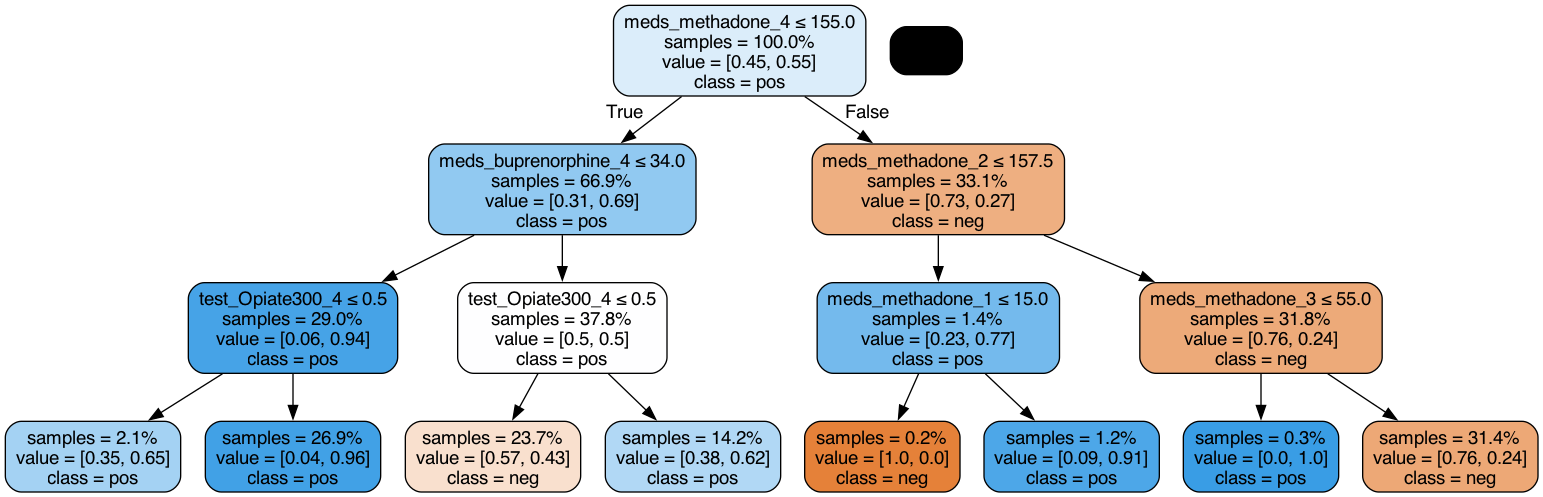

In [49]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Now we will try ensemble learning with Random Forest

## Use Grid Search

In [50]:
# create custom grid search function
def perform_grid_search(X_train, y_train, X_val, y_val, classifier, hyperparams):
    """
    Perform grid search with cross-validation for a given classifier and hyperparameters.

    Parameters:
    - X_train: Training features dataframe.
    - y_train: Training target series.
    - X_val: Validation features dataframe.
    - y_val: Validation target series.
    - classifier: The classifier to use (e.g., XGBClassifier()).
    - hyperparams: Dictionary of hyperparameters to search.

    Returns:
    - best_params: Best hyperparameters found by GridSearchCV.
    - best_model: Best model found by GridSearchCV.
    - c_index: C-index score on the validation set.
    - results_df: DataFrame containing the results of the grid search.
    """
    # Define a custom scoring function for the C-index
    def cindex_score(y_true, y_pred):
        return helper.cindex(y_true, y_pred)

    # Wrap the custom scoring function using make_scorer
    cindex_scorer = make_scorer(cindex_score, greater_is_better=True)

    # Set up GridSearchCV with cross-validation and custom scorer
    grid_search = GridSearchCV(estimator=classifier, param_grid=hyperparams, cv=5, scoring=cindex_scorer, n_jobs=-1, verbose=1)

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best parameters
    best_params = grid_search.best_params_
    

    # Retrieve the best model
    best_model = grid_search.best_estimator_

    # Get the probability scores from the best model
    y_val_preds = best_model.predict_proba(X_val)[:, 1]

    # Calculate the C-index on the validation set
    c_index = helper.cindex(y_val.values, y_val_preds)
    

    # Store the results in a DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)

    return results_df


In [51]:
# Define the classifiers and hyperparameters
classifiers = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    'XGBoost': (XGBClassifier(), {
        'max_depth': [3, 6, 9],
        'learning_rate': [0.001, 0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0, 0.5, 1]
    })
}

# Run grid search for each classifier
results = {}

for clf_name, (clf, params) in classifiers.items():
    print(f"Running grid search for {clf_name}...")
    results[clf_name] = perform_grid_search(X_train, y_train, X_val, y_val, clf, params)
    print()

# Display the results
# print the best params with cindex score for each classifier
for clf_name, df in results.items():
    best_row = df.loc[df['rank_test_score'] == 1]
    best_cindex = best_row['mean_test_score'].values[0]
    best_params = best_row['params'].values[0]

    print(f"{clf_name}:")
    print(f"Best C-index: {best_cindex}")
    print(f"Best hyperparameters: {best_params}")
    print()

Running grid search for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running grid search for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running grid search for XGBoost...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Logistic Regression:
Best C-index: 0.7336668620936747
Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Random Forest:
Best C-index: 0.7525366425640024
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

XGBoost:
Best C-index: 0.7428161031854603
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 1}



## Run each classifier with the best params on the test set

In [54]:
# run each classifier with the best hyperparameters on the test set
for clf_name, (clf, params) in classifiers.items():
    # Initialize the classifier with the best hyperparameters
    best_clf = clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].values[0])

    # Fit the model
    best_clf.fit(X_train, y_train)

    # Get the probability scores
    y_test_preds = best_clf.predict_proba(X_test)[:, 1]

    # Calculate the C-index
    c_index = helper.cindex(y_test.values, y_test_preds)

    print(f"{clf_name} C-Index for test set: {c_index}")
    print()



Logistic Regression C-Index for test set: 0.811252055438102

Random Forest C-Index for test set: 0.8126614987080103

XGBoost C-Index for test set: 0.798332158797275

